#  Core Sequence-Aware Agent Design v2

This experiment explores a transformer-based recurrent PPO agent for financial trading. The environment is sequence-aware and includes both regime-based augmentation and per-episode reward normalization. The agent is evaluated across top 2 stocks in each sector using structured episode sequences to assess learning generalization.

---

##  Experiment Configuration

| Parameter               | Value                         |
|-------------------------|-------------------------------|
| Agent                   | Recurrent PPO + Transformer   |
| Env Wrapper             | RegimeAugmentingWrapper + PerEpisodeRewardNormalizer |
| Episode Length          | 100                           |
| Episodes                | 20                            |
| Eval Episodes           | 3 per iteration               |
| Steps per Update        | 800                           |
| Batch Size              | 100                           |
| Total Timesteps         | 20,000                        |
| Learning Rate           | 0.0003                        |
| Entropy Coefficient     | 0.005                         |
| Value Function Coeff    | 0.5                           |
| Max Gradient Norm       | 0.5                           |
| Normalize Advantage     | True                          |
| Optimizer               | Adam                          |
| Transformer d_model     | 64                            |
| Heads                  | 4                             |
| Layers                 | 2                             |

---

## Environment Setup

- **Train Set:** 2023-01-01 → 2023-07-01
- **Test Set:** 2023-07-01 → 2024-01-01
- **Assets:** Top 2 stocks by sector
- **Sequence Split:** 80% train / 20% eval sequences

---

##  Agent Architecture

- **Feature Extractor:** Transformer encoder with causal mask and learnable positional encoding.
- **Policy Class:** Custom `TransformerPolicy` extending `RecurrentActorCriticPolicy`.
- **Reward Normalization:** Online normalization within episodes.
- **Regime Augmentation:** Appends one-hot encoded market regime to each timestep.

---

## Training Summary (Selected Stats)

| Timesteps | Ep Rew Mean | Explained Variance | Value Loss | Policy Grad Loss |
|-----------|-------------|--------------------|------------|------------------|
|  8000     | 3.21        | 0.15               | 4.68       | -0.00277         |
| 14400     | 2.90        | 0.645              | 1.71       |  0.00163         |
| 20000     | **3.79**    | **0.751**          | 1.59       | -0.00012         |

---

## Evaluation Snapshots

| Timestep | Mean Reward | Std Dev | Eval Length |
|----------|-------------|---------|-------------|
| 5000     | -8.17       | ±8.72   | 102         |
| 10000    | -4.43       | ±7.59   | 102         |
| 15000    | -6.17       | ±4.92   | 102         |
| 20000    | **0.24**    | ±2.86   | 102         |

---

## Statistical Significance

### Paired t-test and Mann-Whitney U-test

| Metric       | t-test p-value | Mann-Whitney p-value |
|--------------|----------------|-----------------------|
| `total_reward` | 0.0300         | 0.0075                |
| `calmar`       | 0.0132         | 0.0075                |

✅ Both `total_reward` and `calmar ratio` show **statistically significant** improvements compared to the baseline.  
Especially, Calmar implies **more stable and risk-adjusted returns**.

> Note: `sharpe`, `sortino`, and `final_wealth` were skipped due to empty values in the evaluation logs. Ensure metrics are logged and valid across all test episodes to include them.

---

## Next Steps

1. **Fix missing metrics** (`sharpe`, `sortino`, etc.) in the logging pipeline.
2. **Plot distribution comparisons** (boxplots, histograms) for rewards and risk-adjusted returns.
3. **Run ablation**:
   - Without regime augmentation
   - Without reward normalization
   - With simpler agents (e.g., MLP or LSTM)
4. **Test in unseen market conditions** or during volatility spikes to check robustness.

---

_Logged using `ExperimentTracker` — Run Hash: `${experiment_tracker.run_hash}`_


In [1]:
# SETUP ===================================
import jupyter
import warnings

from src.utils.system import boot, Notify

boot()
warnings.filterwarnings("ignore")



# PACKAGES ================================
import os
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import  RobustScaler

# FRAMEWORK STUFF =========================
from src.defaults import TOP2_STOCK_BY_SECTOR, FEATURE_COLS,EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
from src.experiments.experiment_tracker import ExperimentTracker
from src.env.base_timeseries_trading_env import BaseSequenceAwareTradingEnv,SequenceAwareAlphaTradingEnv,SequenceAwareBaselineTradingAgent,SequenceAwareCalmarTradingEnv,SequenceAwareCumulativeTradingEnv,SequenceAwareDrawdownTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareSharpeTradingEnv,SequenceAwareSortinoTradingEnv

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy



In [2]:
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces


from src.env.step_rewards import reward_sharpe,reward_sortino,reward_drawdown,reward_alpha,reward_cumulative,reward_calmar,reward_hybrid

class BaseSequenceAwareTradingEnv(gym.Env):
    """
    Flexible RL Trading Env with windowed sequence obs (Transformer/LSTM/MLP-ready).
    - Set `return_sequences=True` for (window_length, obs_dim) obs (for transformers).
    - Set `return_sequences=False` for flat obs (classic RL, SB3 LSTM/MLP).
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self, df, feature_cols=None, reward_fn=None, internal_features=None,
        episode_length=100, transaction_cost=0.0001, seed=314, window_length=10, return_sequences=True):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or []
        self.internal_features = internal_features or [
            "position", "holding_period", "cumulative_reward", "pct_time",
            "drawdown", "rel_perf", "unrealized_pnl", "entry_price", "time_in_position"
        ]
        self.obs_dim = len(self.feature_cols) + len(self.internal_features)
        self.episode_length = episode_length +2
        self.window_length = max(1, window_length)
        self.return_sequences = return_sequences  # True: (window, obs_dim), False: flat
        self.transaction_cost = transaction_cost
        self.seed = seed
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if seed is not None:
            np.random.seed(seed)
        counts = df['symbol'].value_counts()
        eligible = counts[counts >= episode_length].index
        self.stocks = df[df['symbol'].isin(eligible)]['symbol'].unique()
        self.episode_df = df.copy()
        self.reward_fn = reward_fn or self.default_reward_fn

        # Set observation space
        if self.return_sequences:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length, self.obs_dim), dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length * self.obs_dim,), dtype=np.float32
            )
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

    
    def get_current_regime(self):
        """
        Detects current regime based on recent return volatility and trend.
        Returns:
            0 = Bull, 1 = Bear, 2 = Sideways
        """
        if self.current_step < self.window_length:
            return 2  # Not enough data, assume sideways

        # Use recent price changes to detect regime
        returns = self.episode_df['return_1d'].iloc[self.current_step - self.window_length:self.current_step].values
        mean_return = returns.mean()
        std_return = returns.std()

        # Thresholds can be tuned
        if mean_return > 0.001 and std_return < 0.01:
            return 0  # Bull
        elif mean_return < -0.001 and std_return < 0.01:
            return 1  # Bear
        else:
            return 2  # Sideways
        
    def default_reward_fn(self, position, price_change, **kwargs):
        return position * price_change

    def set_episode_sequence(self, sequence):
        self.episode_sequence = sequence
        self.episode_counter = 0

    def generate_episode_sequences_v1(self, train_steps=10000):
        dataset_length = len(self.df)
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        ticker = self.df['symbol'].unique()[0]
        min_start = 0
        max_start = dataset_length - self.episode_length - 2
        for i in range(episodes):
            episode_sequences.append((ticker, np.random.randint(0, max_start)))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def generate_episode_sequences(self, train_steps=10000):
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        for _ in range(episodes):
            ticker = np.random.choice(self.stocks)
            stock_df = self.df[self.df['symbol'] == ticker].reset_index(drop=True)
            max_start = len(stock_df) - self.episode_length - 2
            if max_start <= 0:
                continue  # skip if not enough data
            start = np.random.randint(0, max_start)
            episode_sequences.append((ticker, start))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def reset(self, seed=None, options=None, start_index=None):
        self.entry_step = None
        self.unrealized_pnl = 0
        self.relative_perf = 0
        self.drawdown = 0
        self.time_in_position = 0
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if self.seed is not None:
            np.random.seed(self.seed)
            
            
        symbol, start_idx = self.episode_sequence[self.episode_counter]
        #print(symbol,start_idx,self.df['symbol'].unique())
        symbol_df = self.df[self.df['symbol'] == symbol].reset_index(drop=True)
        #print(len(symbol_df))
        
        if start_idx + self.episode_length > len(symbol_df):
            print(f"[WARN] Episode too short for {symbol} at {start_idx}, skipping...")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()  # tenta o próximo episódio

        # ✅ Extração segura
        #self.episode_df = symbol_df.iloc[start_idx : start_idx + self.episode_length].copy()
        end = start_idx + self.episode_length + 1
        if end > len(symbol_df):
            print(f"[WARN] Not enough data for {symbol} from {start_idx}, skipping.")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()
        self.episode_df = symbol_df.iloc[start_idx:end].copy()
        

        # Move to next episode (with wrap-around)
        self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
        """
        for _ in range(10):  # Try up to 10 times to get a valid episode
            stock = self.stocks[0]
            if hasattr(self, "episode_sequence"):
                if self.episode_counter >= len(self.episode_sequence):
                    self.episode_counter = 0
                _, start = self.episode_sequence[self.episode_counter]
                self.episode_counter += 1
            else:
                stock = np.random.choice(self.stocks)
                stock_df = self.df[self.df['symbol'] == stock].reset_index(drop=True)
                max_start = len(stock_df) - self.episode_length
                if max_start <= 0:
                    continue  # Try another stock
                start = np.random.randint(0, max_start + 1)

            self.stock = stock
            stock_df = self.df[self.df['symbol'] == self.stock].reset_index(drop=True)
            self.episode_df = stock_df.iloc[int(start):int(start) + int(self.episode_length + 2)].reset_index(drop=True)

            if len(self.episode_df) >= self.window_length:
                break
        else:
            raise RuntimeError("Failed to sample a valid episode with sufficient data.")
        """
        self.current_step = 0
        self.entry_price = None
        self.position = 0
        self.holding_period = 0
        self.cumulative_reward = 0
        self.returns_history = []
        self.reward_history = []
        self.episode_pct_changes = self.episode_df['return_1d'].values
        self.max_possible_reward = np.sum(np.abs(self.episode_pct_changes))
        self.current_wealth = 1.0
        self.peak_wealth = 1.0

        return self._get_obs(), {}

    def _get_obs(self):
        # Returns a rolling window of observations (2D or flattened)
        obs_list = []
        #for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
        #    idx = max(i, 0)  # pad with earliest available step
        #    features = self.episode_df.iloc[idx][self.feature_cols].values.astype(np.float32)
        for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
            if 0 <= i < len(self.episode_df):
                features = self.episode_df.iloc[i][self.feature_cols].values.astype(np.float32)
            else:
                features = np.zeros(len(self.feature_cols), dtype=np.float32)  # zero padding
            internal_state = {
                "position": self.position,
                "holding_period": self.holding_period,
                "cumulative_reward": self.cumulative_reward,
                "pct_time": self.current_step / self.episode_length,
                "drawdown": self.drawdown,
                "rel_perf": self.relative_perf,
                "unrealized_pnl": self.unrealized_pnl,
                "entry_price": self.entry_price if self.entry_price is not None else 0.0,
                "time_in_position": self.time_in_position,
            }
            internal = np.array([internal_state[name] for name in self.internal_features], dtype=np.float32)
            obs = np.concatenate([features, internal])
            obs_list.append(obs)
        obs_window = np.stack(obs_list)  # shape: (window_length, obs_dim)
        if self.return_sequences:
            return obs_window  # shape: (window_length, obs_dim)
        else:
            return obs_window.flatten()  # shape: (window_length * obs_dim,)
        
    

    def step(self, action):
        #print(self.current_step,self.episode_length,len(self.episode_df))
        done = self.current_step >= self.episode_length - 1
        current_row = self.episode_df.iloc[self.current_step]

        # Protege contra acesso fora dos limites
        if self.current_step + 1 < len(self.episode_df):
            next_row = self.episode_df.iloc[self.current_step + 1]
        else:
            next_row = current_row.copy()  # fallback seguro

        price_change = next_row['return_1d']
        prev_position = self.position
        reward = 0
        cost = 0

        self.action_counts[action] += 1

        if action == 1:  # Buy
            if self.position != 1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = 1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        elif action == 2:  # Sell
            if self.position != -1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = -1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        if self.position != 0:
            self.holding_period += 1

        step_return = self.position * price_change
        self.returns_history.append(step_return)
        self.current_wealth *= (1 + step_return)
        if self.current_wealth > self.peak_wealth:
            self.peak_wealth = self.current_wealth
        self.drawdown = 1 - self.current_wealth / self.peak_wealth

        if self.position != 0 and self.entry_price is not None:
            current_price = next_row['close']
            self.unrealized_pnl = (current_price - self.entry_price) * self.position / self.entry_price
            self.time_in_position = self.current_step - self.entry_step
        else:
            self.unrealized_pnl = 0
            self.time_in_position = 0

        if 'market_return_1d' in self.episode_df.columns:
            self.relative_perf = price_change - next_row['market_return_1d']
        else:
            self.relative_perf = 0

        reward = self.reward_fn(
            position=self.position,
            price_change=price_change,
            prev_position=prev_position,
            env=self
        )
        reward -= cost
        self.reward_history.append(reward)
        self.cumulative_reward += reward

        self.current_step += 1
        obs = self._get_obs()
        info = {}
        info["regime"] = self.get_current_regime()

        # Calcula métricas no final do episódio
        if done:
            returns = np.array(self.returns_history)
            mean = np.median(returns) if len(returns) > 0 else np.nan
            std = returns.std() if len(returns) > 1 else np.nan
            downside = returns[returns < 0]
            downside_std = downside.std() if len(downside) > 1 else np.nan

            sharpe = mean / std if (std is not None and std > 0 and not np.isnan(std)) else np.nan
            sortino = mean / downside_std if (downside_std is not None and downside_std > 0 and not np.isnan(downside_std)) else np.nan

            wealth_curve = np.cumprod(1 + returns) if len(returns) > 0 else np.array([])
            peak_wealth = np.maximum.accumulate(wealth_curve) if len(wealth_curve) > 0 else np.array([])
            drawdowns = (wealth_curve - peak_wealth) / (peak_wealth + 1e-8) if len(wealth_curve) > 0 else np.array([])
            max_drawdown = np.abs(drawdowns.min()) if len(drawdowns) > 0 else np.nan
            calmar = ((wealth_curve[-1] - 1) / max_drawdown) if (len(wealth_curve) > 0 and max_drawdown and not np.isnan(max_drawdown) and max_drawdown > 0) else np.nan
            cum_return = wealth_curve[-1] - 1 if len(wealth_curve) > 0 else np.nan
            final_wealth = wealth_curve[-1] if len(wealth_curve) > 0 else np.nan

            # Trade-level metrics
            trades = []
            trade_profits = []
            prev = 0
            for i, ret in enumerate(returns):
                if prev == 0 and ret != 0:
                    entry_idx = i
                    entry_dir = np.sign(ret)
                elif prev != 0 and (ret == 0 or np.sign(ret) != np.sign(prev)):
                    if 'entry_idx' in locals():
                        trade = returns[entry_idx:i+1]
                        trade_profits.append(np.sum(trade))
                        del entry_idx
                prev = ret
            win_rate = np.median(np.array(trade_profits) > 0) if trade_profits else np.nan

            if 'market_return_1d' in self.episode_df.columns:
                market_returns = self.episode_df['market_return_1d'].values[1:self.episode_length]
                market_wealth_curve = np.cumprod(1 + market_returns) if len(market_returns) > 0 else np.array([])
                market_cum_return = market_wealth_curve[-1] - 1 if len(market_wealth_curve) > 0 else np.nan
                alpha = cum_return - market_cum_return if cum_return is not None and not np.isnan(cum_return) and market_cum_return is not None and not np.isnan(market_cum_return) else np.nan
            else:
                alpha = np.nan

            info.update({
                "episode_sharpe": sharpe,
                "episode_sortino": sortino,
                "episode_total_reward": np.sum(self.reward_history) if len(self.reward_history) > 0 else np.nan,
                "cumulative_return": cum_return,
                "calmar": calmar,
                "max_drawdown": max_drawdown,
                "win_rate": win_rate,
                "alpha": alpha,
                "returns": returns,
                "market_returns": market_returns if 'market_returns' in locals() else [],
                "downside": downside,
                "regime": self.get_current_regime(),
                "final_wealth": final_wealth,
                "action_hold_count": self.action_counts[0],
                "action_buy_count": self.action_counts[1],
                "action_sell_count": self.action_counts[2]
            })

        return obs, reward, done, False, info

    def render(self):
        print(f"Step: {self.current_step} | Pos: {self.position} | Hold: {self.holding_period} | CumRew: {self.cumulative_reward:.4f}")



class SequenceAwareSharpeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sharpe, **kwargs)

class SequenceAwareSortinoTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sortino, **kwargs)

class SequenceAwareAlphaTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_alpha, **kwargs)

class SequenceAwareDrawdownTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_drawdown, **kwargs)

class SequenceAwareCumulativeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_cumulative, **kwargs)

class SequenceAwareCalmarTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_calmar, **kwargs)

class SequenceAwareHybridTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_hybrid, **kwargs)

class SequenceAwareBaselineTradingAgent:
    def __init__(self,df,feature_cols=[],
            episode_length=100, seed=314,set_episode_sequence=[]):
    
        self.env = BaseSequenceAwareTradingEnv(df, feature_cols=feature_cols,
            episode_length=episode_length, seed=seed)
        self.env.set_episode_sequence(set_episode_sequence)
        
    def predict(self,obs,*args,**kwargs):
        #print(self.env.stocks,'xxxxxxxxxxx')
        return self.env.action_space.sample(),{}
    
    def set_episode_sequence(self,seq):
        
        pass

    
    
# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # should return 0, 1, or 2
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

In [3]:

# ========== CONFIG ==========
EXPERIENCE_NAME = "core_sequence_aware_agent_design_v2"
RESULTS_PATH = f"data/experiments/{EXPERIENCE_NAME}_barebones_results.csv"
N_EPISODES = 20
N_SEEDS = 3
N_EVAL_EPISODES = 3

WINDOW_LENGTH = 10  
TOTAL_TIMESTEPS = EPISODE_LENGTH * 150
N_STEPS = EPISODE_LENGTH * 2

TRANSACTION_COST = 0

CONFIG = {
    "batch_size": EPISODE_LENGTH,
    "n_steps": 800,
    "total_timesteps": TOTAL_TIMESTEPS,
    "project_name":EXPERIENCE_NAME,
    "environment": "SequenceAwareCumulativeTradingEnv"
}




# Load data ==================================
ohlcv_df = load_base_dataframe()

# Experiment tracker ========================= 
experiment_tracker = ExperimentTracker(EXPERIENCE_NAME)
experiment_tracker.set_hash(CONFIG)

# Files ======================================
checkpoint_path = "data/checkpoint" 
checkpoint_name = "-8377624099423380081"#experiment_tracker.run_hash
checkpoint_preffix = f"{checkpoint_name}--checkpoint"
checkpoint_best_model=f"{checkpoint_path}/{checkpoint_name}--best_model"
log_path="data/logs"
save_path= f"{checkpoint_path}/{checkpoint_name}--final"
print(checkpoint_name)
#data/checkpoint/-8377624099423380081--final
#data/checkpoint/-3848392742194634112--best_model

-8377624099423380081


In [4]:
EPISODE_LENGTH = 100
MAX_LENGTH = 200
SAVE_FREQ=10000
EVAL_FREQ=5000
TOTAL_TIMESTEPS=1_200_000
#TOTAL_TIMESTEPS=1000
EPISODES_PER_UPDATE = 8          # ~how many episodes before PPO updates
EPISODES_PER_BATCH = 1           # number of full episodes per batch

# === Auto-derive PPO settings ===
N_STEPS = EPISODE_LENGTH * EPISODES_PER_UPDATE
BATCH_SIZE = EPISODE_LENGTH * EPISODES_PER_BATCH

ENV_CLASS = SequenceAwareCumulativeTradingEnv

n = Notify(experiment_tracker.project)
n.info('START')
print(N_STEPS,BATCH_SIZE)

800 100


In [5]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=MAX_LENGTH):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================================
train_df = ohlcv_df[(ohlcv_df['date']>="2023-01-01") & (ohlcv_df['date']<"2023-07-01")]
test_df = ohlcv_df[(ohlcv_df['date']>="2023-07-01") & (ohlcv_df['date']<"2024-01-01")]
train_df = train_df[train_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]

train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
test_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
# Train on few episodes to prove a point only
train_seq = train_env.generate_episode_sequences(TOTAL_TIMESTEPS)
_test_seq = test_env.generate_episode_sequences(int(TOTAL_TIMESTEPS))
episodes = _test_seq
unique_episodes = {}
for ticker, start in episodes:
    if ticker not in unique_episodes:
        unique_episodes[ticker] = start
# Convert back to a list of tuples
test_seq = [(ticker, start) for ticker, start in unique_episodes.items()]

print(f"Training on {len(train_seq)} different episodes accross the top 2 stocks for each sector")
print(f"Testing on {len(test_seq)} different episodes accross the top 2 stocks for each sector")
def train_agent():
    
    
    
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ, save_path=checkpoint_path, name_prefix=checkpoint_preffix
    )

    eval_callback = EvalCallback(
        eval_env, best_model_save_path=checkpoint_best_model,
        log_path=log_path, eval_freq=EVAL_FREQ, deterministic=True
    )

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])
    model.save(save_path)

if __name__ == "__main__":
    train_agent()


Training on 11765 different episodes accross the top 2 stocks for each sector
Testing on 22 different episodes accross the top 2 stocks for each sector
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.82     |
| time/              |          |
|    fps             | 154      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 800      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.61        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 1600        |
| train/                  |         

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -2.04       |
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 11          |
|    time_elapsed         | 378         |
|    total_timesteps      | 8800        |
| train/                  |             |
|    approx_kl            | 0.004720585 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.968      |
|    explained_variance   | -0.0579     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.54        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00613    |
|    value_loss           | 9.04        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -1.73    |
| time/              |          |
|    fps             | 22       |
|    iterations      | 19       |
|    time_elapsed    | 666      |
|    total_timesteps | 15200    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -1.03       |
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 20          |
|    time_elapsed         | 699         |
|    total_timesteps      | 16000       |
| train/                  |             |
|    approx_kl            | 0.008810684 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | -0.083      |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.6         |
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 29          |
|    time_elapsed         | 1031        |
|    total_timesteps      | 23200       |
| train/                  |             |
|    approx_kl            | 0.010987782 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.892      |
|    explained_variance   | 0.0587      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.15        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.00416     |
|    value_loss           | 6.3         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=30000, episode_reward=3.02 +/- 13.57
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 3.02       |
| time/                   |            |
|    total_timesteps      | 30000      |
| train/                  |            |
|    approx_kl            | 0.01523409 |
|    clip_fraction        | 0.038      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.815     |
|    explained_variance   | -0.0149    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.55       |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 5.07       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.37     |
| time/              |          |
|   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.41        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 47          |
|    time_elapsed         | 1712        |
|    total_timesteps      | 37600       |
| train/                  |             |
|    approx_kl            | 0.009525886 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.654      |
|    explained_variance   | -0.112      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.64        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.000661   |
|    value_loss           | 5.43        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.86        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 56          |
|    time_elapsed         | 2056        |
|    total_timesteps      | 44800       |
| train/                  |             |
|    approx_kl            | 0.011343813 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.593      |
|    explained_variance   | 0.00248     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.34        |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.000599   |
|    value_loss           | 5.71        |
-----------------------------------------
Eval num_timesteps=45000, episode_reward=-0.65 +/- 7.65
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.87        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 65          |
|    time_elapsed         | 2392        |
|    total_timesteps      | 52000       |
| train/                  |             |
|    approx_kl            | 0.012073571 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.516      |
|    explained_variance   | 0.0785      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.81        |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00831    |
|    value_loss           | 4.34        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 4.02         |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 74           |
|    time_elapsed         | 2742         |
|    total_timesteps      | 59200        |
| train/                  |              |
|    approx_kl            | 0.0012311947 |
|    clip_fraction        | 0.0055       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.552       |
|    explained_variance   | 0.356        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03         |
|    n_updates            | 730          |
|    policy_gradient_loss | 2.73e-05     |
|    value_loss           | 3.15         |
------------------------------------------
Eval num_timesteps=60000, episode_reward=6.18 +/- 12.11
Episode length: 102.00 +/- 0.00
---------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.63     |
| time/              |          |
|    fps             | 21       |
|    iterations      | 82       |
|    time_elapsed    | 3047     |
|    total_timesteps | 65600    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 4.31         |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 83           |
|    time_elapsed         | 3081         |
|    total_timesteps      | 66400        |
| train/                  |              |
|    approx_kl            | 0.0042599216 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.368       |
|    explained_variance   | 0.469        |
|    learning_r

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 1.04         |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 92           |
|    time_elapsed         | 3421         |
|    total_timesteps      | 73600        |
| train/                  |              |
|    approx_kl            | 0.0032625892 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.411       |
|    explained_variance   | 0.0849       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.972        |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 3.52         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -1.05    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 100      |
|    time_elapsed    | 3733     |
|    total_timesteps | 80000    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | -0.0553      |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 101          |
|    time_elapsed         | 3769         |
|    total_timesteps      | 80800        |
| train/                  |              |
|    approx_kl            | 0.0144725265 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.411       |
|    explained_variance   | 0.346        |
|    learning_r

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.01        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 110         |
|    time_elapsed         | 4103        |
|    total_timesteps      | 88000       |
| train/                  |             |
|    approx_kl            | 0.019326102 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.395      |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.754       |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.00792    |
|    value_loss           | 5.75        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=95000, episode_reward=14.18 +/- 6.04
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 14.2        |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.024396727 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.578      |
|    explained_variance   | 0.0907      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.75        |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.00496    |
|    value_loss           | 5.24        |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 0.854    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.46        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 128         |
|    time_elapsed         | 4792        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.043257758 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.519      |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.56        |
|    n_updates            | 1270        |
|    policy_gradient_loss | 0.00395     |
|    value_loss           | 6.1         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 1.92         |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 137          |
|    time_elapsed         | 5136         |
|    total_timesteps      | 109600       |
| train/                  |              |
|    approx_kl            | 0.0046187975 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.605       |
|    explained_variance   | 0.412        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.65         |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 4.28         |
------------------------------------------
Eval num_timesteps=110000, episode_reward=7.96 +/- 7.06
Episode length: 102.00 +/- 0.00
---------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -0.0591     |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 146         |
|    time_elapsed         | 5481        |
|    total_timesteps      | 116800      |
| train/                  |             |
|    approx_kl            | 0.022689577 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.821      |
|    explained_variance   | 0.0246      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.65        |
|    n_updates            | 1450        |
|    policy_gradient_loss | 0.00173     |
|    value_loss           | 3.89        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -0.0674     |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 156         |
|    time_elapsed         | 5857        |
|    total_timesteps      | 124800      |
| train/                  |             |
|    approx_kl            | 0.031751387 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.813      |
|    explained_variance   | 0.0964      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.454       |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 4.81        |
-----------------------------------------
Eval num_timesteps=125000, episode_reward=-2.70 +/- 11.19
Episode length: 102.00 +/- 0.00
----------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 165        |
|    time_elapsed         | 6203       |
|    total_timesteps      | 132000     |
| train/                  |            |
|    approx_kl            | 0.04579757 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.65      |
|    explained_variance   | 0.0362     |
|    learning_rate        | 0.0003     |
|    loss                 | 3.95       |
|    n_updates            | 1640       |
|    policy_gradient_loss | 0.00306    |
|    value_loss           | 3.53       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

Eval num_timesteps=140000, episode_reward=4.42 +/- 8.32
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 4.42        |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.057684444 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.645      |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73        |
|    n_updates            | 1740        |
|    policy_gradient_loss | -0.001      |
|    value_loss           | 3.22        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.09     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.31        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 184         |
|    time_elapsed         | 6926        |
|    total_timesteps      | 147200      |
| train/                  |             |
|    approx_kl            | 0.028124416 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.618      |
|    explained_variance   | -0.323      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.2         |
|    n_updates            | 1830        |
|    policy_gradient_loss | -0.00442    |
|    value_loss           | 7.03        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=155000, episode_reward=1.64 +/- 8.44
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 1.64        |
| time/                   |             |
|    total_timesteps      | 155000      |
| train/                  |             |
|    approx_kl            | 0.031421974 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.717      |
|    explained_variance   | 0.349       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.44        |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.00193    |
|    value_loss           | 3.61        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.42     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 203         |
|    time_elapsed         | 7650        |
|    total_timesteps      | 162400      |
| train/                  |             |
|    approx_kl            | 0.054228842 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.786      |
|    explained_variance   | 0.311       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.15        |
|    n_updates            | 2020        |
|    policy_gradient_loss | 0.0157      |
|    value_loss           | 4.37        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=170000, episode_reward=2.45 +/- 8.05
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 2.45        |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.021218538 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.76       |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.73        |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.0091     |
|    value_loss           | 5.85        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.15     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 222         |
|    time_elapsed         | 8371        |
|    total_timesteps      | 177600      |
| train/                  |             |
|    approx_kl            | 0.013879181 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.747      |
|    explained_variance   | 0.58        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.46        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00843    |
|    value_loss           | 3.42        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 231         |
|    time_elapsed         | 8703        |
|    total_timesteps      | 184800      |
| train/                  |             |
|    approx_kl            | 0.028457005 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.785      |
|    explained_variance   | -0.0683     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.86        |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.00761    |
|    value_loss           | 5.35        |
-----------------------------------------
Eval num_timesteps=185000, episode_reward=9.58 +/- 9.03
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.14        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 240         |
|    time_elapsed         | 9058        |
|    total_timesteps      | 192000      |
| train/                  |             |
|    approx_kl            | 0.023721209 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.85       |
|    explained_variance   | 0.119       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.814       |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.00742    |
|    value_loss           | 4.64        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.23        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 249         |
|    time_elapsed         | 9394        |
|    total_timesteps      | 199200      |
| train/                  |             |
|    approx_kl            | 0.030717753 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.735      |
|    explained_variance   | -0.23       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 2480        |
|    policy_gradient_loss | -0.00682    |
|    value_loss           | 10.6        |
-----------------------------------------
Eval num_timesteps=200000, episode_reward=5.27 +/- 6.48
Episode length: 102.00 +/- 0.00
------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 258        |
|    time_elapsed         | 9738       |
|    total_timesteps      | 206400     |
| train/                  |            |
|    approx_kl            | 0.04558678 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.705     |
|    explained_variance   | -0.232     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.27       |
|    n_updates            | 2570       |
|    policy_gradient_loss | -0.00484   |
|    value_loss           | 4.35       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 268         |
|    time_elapsed         | 10115       |
|    total_timesteps      | 214400      |
| train/                  |             |
|    approx_kl            | 0.027066603 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.668      |
|    explained_variance   | 0.0519      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.98        |
|    n_updates            | 2670        |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 5.02        |
-----------------------------------------
Eval num_timesteps=215000, episode_reward=0.94 +/- 4.27
Episode length: 102.00 +/- 0.00
------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 277        |
|    time_elapsed         | 10462      |
|    total_timesteps      | 221600     |
| train/                  |            |
|    approx_kl            | 0.08026632 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.697     |
|    explained_variance   | 0.161      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.21       |
|    n_updates            | 2760       |
|    policy_gradient_loss | -0.0045    |
|    value_loss           | 3.44       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 0.49       |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 287        |
|    time_elapsed         | 10858      |
|    total_timesteps      | 229600     |
| train/                  |            |
|    approx_kl            | 0.03654624 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.654     |
|    explained_variance   | 0.189      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.46       |
|    n_updates            | 2860       |
|    policy_gradient_loss | 0.0012     |
|    value_loss           | 7.32       |
----------------------------------------
Eval num_timesteps=230000, episode_reward=6.41 +/- 14.92
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 0.155       |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 296         |
|    time_elapsed         | 11212       |
|    total_timesteps      | 236800      |
| train/                  |             |
|    approx_kl            | 0.039545365 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.726      |
|    explained_variance   | -0.00509    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 2950        |
|    policy_gradient_loss | -0.00652    |
|    value_loss           | 4.74        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.22        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 306         |
|    time_elapsed         | 11604       |
|    total_timesteps      | 244800      |
| train/                  |             |
|    approx_kl            | 0.040661447 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.866      |
|    explained_variance   | 0.0664      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.07        |
|    n_updates            | 3050        |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 3.81        |
-----------------------------------------
Eval num_timesteps=245000, episode_reward=-3.30 +/- 6.00
Episode length: 102.00 +/- 0.00
-----------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 315        |
|    time_elapsed         | 11958      |
|    total_timesteps      | 252000     |
| train/                  |            |
|    approx_kl            | 0.03399079 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.807     |
|    explained_variance   | 0.109      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.39       |
|    n_updates            | 3140       |
|    policy_gradient_loss | -0.00404   |
|    value_loss           | 6.95       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

Eval num_timesteps=260000, episode_reward=-0.42 +/- 4.44
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -0.421      |
| time/                   |             |
|    total_timesteps      | 260000      |
| train/                  |             |
|    approx_kl            | 0.025823118 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.784      |
|    explained_variance   | 0.304       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.96        |
|    n_updates            | 3240        |
|    policy_gradient_loss | -0.00722    |
|    value_loss           | 4.09        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.91     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.58        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 334         |
|    time_elapsed         | 12696       |
|    total_timesteps      | 267200      |
| train/                  |             |
|    approx_kl            | 0.027291559 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.659      |
|    explained_variance   | 0.449       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.75        |
|    n_updates            | 3330        |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 4.76        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=275000, episode_reward=11.88 +/- 11.35
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 11.9        |
| time/                   |             |
|    total_timesteps      | 275000      |
| train/                  |             |
|    approx_kl            | 0.030141678 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.113       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.45        |
|    n_updates            | 3430        |
|    policy_gradient_loss | -0.00856    |
|    value_loss           | 3.91        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.15     |
| time/           

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 353        |
|    time_elapsed         | 13429      |
|    total_timesteps      | 282400     |
| train/                  |            |
|    approx_kl            | 0.04273896 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.799     |
|    explained_variance   | 0.187      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.07       |
|    n_updates            | 3520       |
|    policy_gradient_loss | 0.00402    |
|    value_loss           | 6.46       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

Eval num_timesteps=290000, episode_reward=6.26 +/- 14.84
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 6.26        |
| time/                   |             |
|    total_timesteps      | 290000      |
| train/                  |             |
|    approx_kl            | 0.034224983 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.662      |
|    explained_variance   | 0.56        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.05        |
|    n_updates            | 3620        |
|    policy_gradient_loss | -0.00766    |
|    value_loss           | 2.82        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3        |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 372         |
|    time_elapsed         | 14167       |
|    total_timesteps      | 297600      |
| train/                  |             |
|    approx_kl            | 0.025938123 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.186       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.68        |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.0095     |
|    value_loss           | 5.02        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=305000, episode_reward=-13.84 +/- 5.60
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -13.8       |
| time/                   |             |
|    total_timesteps      | 305000      |
| train/                  |             |
|    approx_kl            | 0.045454707 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.84       |
|    explained_variance   | 0.0035      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.924       |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.00935    |
|    value_loss           | 3.04        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.09     |
| time/           

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.39        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 391         |
|    time_elapsed         | 14936       |
|    total_timesteps      | 312800      |
| train/                  |             |
|    approx_kl            | 0.027053848 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.818      |
|    explained_variance   | 0.304       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.921       |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 3.63        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.99     |
| time/              |          |
|    fps             | 20       |
|    iterations      | 400      |
|    time_elapsed    | 15306    |
|    total_timesteps | 320000   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.97        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 401         |
|    time_elapsed         | 15343       |
|    total_timesteps      | 320800      |
| train/                  |             |
|    approx_kl            | 0.037930075 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.785      |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 410         |
|    time_elapsed         | 15707       |
|    total_timesteps      | 328000      |
| train/                  |             |
|    approx_kl            | 0.057615653 |
|    clip_fraction        | 0.313       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.837      |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.68        |
|    n_updates            | 4090        |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 4.02        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=335000, episode_reward=9.71 +/- 7.11
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 9.71        |
| time/                   |             |
|    total_timesteps      | 335000      |
| train/                  |             |
|    approx_kl            | 0.031733826 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.69       |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.536       |
|    n_updates            | 4180        |
|    policy_gradient_loss | 0.000423    |
|    value_loss           | 4.21        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.42     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.97        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 428         |
|    time_elapsed         | 16489       |
|    total_timesteps      | 342400      |
| train/                  |             |
|    approx_kl            | 0.026579062 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.696      |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21        |
|    n_updates            | 4270        |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 3.21        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=350000, episode_reward=7.37 +/- 10.50
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 7.37        |
| time/                   |             |
|    total_timesteps      | 350000      |
| train/                  |             |
|    approx_kl            | 0.034984116 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.648      |
|    explained_variance   | 0.428       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.608       |
|    n_updates            | 4370        |
|    policy_gradient_loss | -0.00377    |
|    value_loss           | 3.1         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.57     |
| time/            

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 5.28       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 447        |
|    time_elapsed         | 17333      |
|    total_timesteps      | 357600     |
| train/                  |            |
|    approx_kl            | 0.03358292 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.718     |
|    explained_variance   | 0.383      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.439      |
|    n_updates            | 4460       |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 2.66       |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       |
|    ep_rew_mean   

Eval num_timesteps=365000, episode_reward=9.51 +/- 8.42
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 9.51        |
| time/                   |             |
|    total_timesteps      | 365000      |
| train/                  |             |
|    approx_kl            | 0.032686405 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.749      |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.33        |
|    n_updates            | 4560        |
|    policy_gradient_loss | 0.00176     |
|    value_loss           | 4.3         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.45     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.53        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 466         |
|    time_elapsed         | 18182       |
|    total_timesteps      | 372800      |
| train/                  |             |
|    approx_kl            | 0.021748813 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.787      |
|    explained_variance   | 0.48        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.63        |
|    n_updates            | 4650        |
|    policy_gradient_loss | -0.00826    |
|    value_loss           | 4.28        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.42     |
| time/              |          |
|    fps             | 20       |
|    iterations      | 475      |
|    time_elapsed    | 18618    |
|    total_timesteps | 380000   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 476         |
|    time_elapsed         | 18676       |
|    total_timesteps      | 380800      |
| train/                  |             |
|    approx_kl            | 0.027436078 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.877      |
|    explained_variance   | 0.283       |
|    learning_rate        | 0.

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 485        |
|    time_elapsed         | 19113      |
|    total_timesteps      | 388000     |
| train/                  |            |
|    approx_kl            | 0.03239344 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.761     |
|    explained_variance   | 0.0877     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.544      |
|    n_updates            | 4840       |
|    policy_gradient_loss | 0.00288    |
|    value_loss           | 4.4        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

Eval num_timesteps=395000, episode_reward=-6.86 +/- 6.82
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -6.86       |
| time/                   |             |
|    total_timesteps      | 395000      |
| train/                  |             |
|    approx_kl            | 0.022372749 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.849      |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.51        |
|    n_updates            | 4930        |
|    policy_gradient_loss | 0.00367     |
|    value_loss           | 4.35        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.46     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 503         |
|    time_elapsed         | 20095       |
|    total_timesteps      | 402400      |
| train/                  |             |
|    approx_kl            | 0.030004073 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.855      |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.687       |
|    n_updates            | 5020        |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 3.56        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=410000, episode_reward=5.35 +/- 9.29
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 5.35        |
| time/                   |             |
|    total_timesteps      | 410000      |
| train/                  |             |
|    approx_kl            | 0.046018798 |
|    clip_fraction        | 0.413       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.854      |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.74        |
|    n_updates            | 5120        |
|    policy_gradient_loss | -0.00367    |
|    value_loss           | 4.97        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.59     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.89        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 522         |
|    time_elapsed         | 21083       |
|    total_timesteps      | 417600      |
| train/                  |             |
|    approx_kl            | 0.032807946 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.877      |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.06        |
|    n_updates            | 5210        |
|    policy_gradient_loss | 0.000162    |
|    value_loss           | 3.91        |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       

Eval num_timesteps=425000, episode_reward=4.48 +/- 8.31
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 4.48        |
| time/                   |             |
|    total_timesteps      | 425000      |
| train/                  |             |
|    approx_kl            | 0.029308882 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.896      |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.701       |
|    n_updates            | 5310        |
|    policy_gradient_loss | 0.00234     |
|    value_loss           | 5.16        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.17     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.51        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 541         |
|    time_elapsed         | 22410       |
|    total_timesteps      | 432800      |
| train/                  |             |
|    approx_kl            | 0.024535226 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.874      |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.63        |
|    n_updates            | 5400        |
|    policy_gradient_loss | -0.00689    |
|    value_loss           | 4.83        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.94     |
| time/              |          |
|    fps             | 19       |
|    iterations      | 550      |
|    time_elapsed    | 22994    |
|    total_timesteps | 440000   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.95        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 551         |
|    time_elapsed         | 23061       |
|    total_timesteps      | 440800      |
| train/                  |             |
|    approx_kl            | 0.026721887 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.959      |
|    explained_variance   | 0.352       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.27        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 560         |
|    time_elapsed         | 23532       |
|    total_timesteps      | 448000      |
| train/                  |             |
|    approx_kl            | 0.024667392 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.844      |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.23        |
|    n_updates            | 5590        |
|    policy_gradient_loss | 0.000331    |
|    value_loss           | 5.02        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.4      |
| time/              |          |
|    fps             | 18       |
|    iterations      | 569      |
|    time_elapsed    | 24102    |
|    total_timesteps | 455200   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.75        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 570         |
|    time_elapsed         | 24176       |
|    total_timesteps      | 456000      |
| train/                  |             |
|    approx_kl            | 0.027629219 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.826      |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       |
|    ep_rew_mean          | 6.99      |
| time/                   |           |
|    fps                  | 18        |
|    iterations           | 579       |
|    time_elapsed         | 24880     |
|    total_timesteps      | 463200    |
| train/                  |           |
|    approx_kl            | 0.0228073 |
|    clip_fraction        | 0.276     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.821    |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.972     |
|    n_updates            | 5780      |
|    policy_gradient_loss | -0.0109   |
|    value_loss           | 4.2       |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.99  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.77     |
| time/              |          |
|    fps             | 18       |
|    iterations      | 588      |
|    time_elapsed    | 25581    |
|    total_timesteps | 470400   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 589         |
|    time_elapsed         | 25665       |
|    total_timesteps      | 471200      |
| train/                  |             |
|    approx_kl            | 0.039624307 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.65       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 0.214       |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 598         |
|    time_elapsed         | 26421       |
|    total_timesteps      | 478400      |
| train/                  |             |
|    approx_kl            | 0.012837901 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.596      |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.29        |
|    n_updates            | 5970        |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 5.8         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=485000, episode_reward=0.52 +/- 10.64
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 0.517       |
| time/                   |             |
|    total_timesteps      | 485000      |
| train/                  |             |
|    approx_kl            | 0.011775069 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.901       |
|    n_updates            | 6060        |
|    policy_gradient_loss | -0.00323    |
|    value_loss           | 2.9         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 0.382    |
| time/            

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 0.581      |
| time/                   |            |
|    fps                  | 17         |
|    iterations           | 616        |
|    time_elapsed         | 27844      |
|    total_timesteps      | 492800     |
| train/                  |            |
|    approx_kl            | 0.01300366 |
|    clip_fraction        | 0.067      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.442     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.776      |
|    n_updates            | 6150       |
|    policy_gradient_loss | -0.00511   |
|    value_loss           | 3.42       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.6      |
| time/              |          |
|    fps             | 17       |
|    iterations      | 625      |
|    time_elapsed    | 28778    |
|    total_timesteps | 500000   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 17         |
|    iterations           | 626        |
|    time_elapsed         | 28846      |
|    total_timesteps      | 500800     |
| train/                  |            |
|    approx_kl            | 0.01027818 |
|    clip_fraction        | 0.0877     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.0003     |
|   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 17         |
|    iterations           | 635        |
|    time_elapsed         | 29643      |
|    total_timesteps      | 508000     |
| train/                  |            |
|    approx_kl            | 0.06358646 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.522     |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.12       |
|    n_updates            | 6340       |
|    policy_gradient_loss | 0.01       |
|    value_loss           | 3.39       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.92     |
| time/              |          |
|    fps             | 16       |
|    iterations      | 644      |
|    time_elapsed    | 30608    |
|    total_timesteps | 515200   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.9         |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 645         |
|    time_elapsed         | 30687       |
|    total_timesteps      | 516000      |
| train/                  |             |
|    approx_kl            | 0.023669388 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.41       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 2.91         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 654          |
|    time_elapsed         | 31406        |
|    total_timesteps      | 523200       |
| train/                  |              |
|    approx_kl            | 0.0039669373 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.876        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.375        |
|    n_updates            | 6530         |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 2.51         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

Eval num_timesteps=530000, episode_reward=4.84 +/- 13.63
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 4.84        |
| time/                   |             |
|    total_timesteps      | 530000      |
| train/                  |             |
|    approx_kl            | 0.019573089 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.455      |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.8         |
|    n_updates            | 6620        |
|    policy_gradient_loss | -0.00546    |
|    value_loss           | 2.5         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.87     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.86        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 672         |
|    time_elapsed         | 32635       |
|    total_timesteps      | 537600      |
| train/                  |             |
|    approx_kl            | 0.021673089 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.569      |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.592       |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 2.89        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.86        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 681         |
|    time_elapsed         | 33167       |
|    total_timesteps      | 544800      |
| train/                  |             |
|    approx_kl            | 0.014902305 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.817      |
|    explained_variance   | 0.688       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.3         |
|    n_updates            | 6800        |
|    policy_gradient_loss | -0.00689    |
|    value_loss           | 6.17        |
-----------------------------------------
Eval num_timesteps=545000, episode_reward=2.11 +/- 9.18
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.94        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 690         |
|    time_elapsed         | 33640       |
|    total_timesteps      | 552000      |
| train/                  |             |
|    approx_kl            | 0.040413678 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.976      |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.45        |
|    n_updates            | 6890        |
|    policy_gradient_loss | 0.00514     |
|    value_loss           | 4.58        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.6         |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 699         |
|    time_elapsed         | 34135       |
|    total_timesteps      | 559200      |
| train/                  |             |
|    approx_kl            | 0.041780338 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.835      |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.65        |
|    n_updates            | 6980        |
|    policy_gradient_loss | -0.00276    |
|    value_loss           | 2.87        |
-----------------------------------------
Eval num_timesteps=560000, episode_reward=4.25 +/- 7.15
Episode length: 102.00 +/- 0.00
------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.44     |
| time/              |          |
|    fps             | 16       |
|    iterations      | 707      |
|    time_elapsed    | 34546    |
|    total_timesteps | 565600   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.71        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 708         |
|    time_elapsed         | 34594       |
|    total_timesteps      | 566400      |
| train/                  |             |
|    approx_kl            | 0.010217987 |
|    clip_fraction        | 0.0967      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.18        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 717         |
|    time_elapsed         | 35055       |
|    total_timesteps      | 573600      |
| train/                  |             |
|    approx_kl            | 0.005066124 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.786      |
|    explained_variance   | 0.722       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.32        |
|    n_updates            | 7160        |
|    policy_gradient_loss | -0.00175    |
|    value_loss           | 2.7         |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 7.79       |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 726        |
|    time_elapsed         | 35525      |
|    total_timesteps      | 580800     |
| train/                  |            |
|    approx_kl            | 0.05785896 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.538     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.25       |
|    n_updates            | 7250       |
|    policy_gradient_loss | 0.0204     |
|    value_loss           | 4.68       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.03        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 736         |
|    time_elapsed         | 36098       |
|    total_timesteps      | 588800      |
| train/                  |             |
|    approx_kl            | 0.010585687 |
|    clip_fraction        | 0.0832      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.722      |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.72        |
|    n_updates            | 7350        |
|    policy_gradient_loss | -0.00577    |
|    value_loss           | 2.85        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 5.4          |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 745          |
|    time_elapsed         | 36675        |
|    total_timesteps      | 596000       |
| train/                  |              |
|    approx_kl            | 0.0064041046 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.666       |
|    explained_variance   | 0.839        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.26         |
|    n_updates            | 7440         |
|    policy_gradient_loss | 0.00298      |
|    value_loss           | 4.33         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 7.58        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 754         |
|    time_elapsed         | 37236       |
|    total_timesteps      | 603200      |
| train/                  |             |
|    approx_kl            | 0.014080429 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.533      |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.1         |
|    n_updates            | 7530        |
|    policy_gradient_loss | 0.0109      |
|    value_loss           | 5.35        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=610000, episode_reward=8.65 +/- 6.99
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 8.65        |
| time/                   |             |
|    total_timesteps      | 610000      |
| train/                  |             |
|    approx_kl            | 0.023895677 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.738      |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.655       |
|    n_updates            | 7620        |
|    policy_gradient_loss | 0.0129      |
|    value_loss           | 4.01        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.74     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 772         |
|    time_elapsed         | 38391       |
|    total_timesteps      | 617600      |
| train/                  |             |
|    approx_kl            | 0.005576065 |
|    clip_fraction        | 0.0919      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.67       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.758       |
|    n_updates            | 7710        |
|    policy_gradient_loss | 0.0013      |
|    value_loss           | 3.27        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.55        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 781         |
|    time_elapsed         | 38987       |
|    total_timesteps      | 624800      |
| train/                  |             |
|    approx_kl            | 0.033419516 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.518      |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.37        |
|    n_updates            | 7800        |
|    policy_gradient_loss | 0.00379     |
|    value_loss           | 4.46        |
-----------------------------------------
Eval num_timesteps=625000, episode_reward=0.83 +/- 5.08
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.54        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 790         |
|    time_elapsed         | 39538       |
|    total_timesteps      | 632000      |
| train/                  |             |
|    approx_kl            | 0.014312398 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.578      |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.532       |
|    n_updates            | 7890        |
|    policy_gradient_loss | -0.0075     |
|    value_loss           | 3.64        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 799         |
|    time_elapsed         | 40030       |
|    total_timesteps      | 639200      |
| train/                  |             |
|    approx_kl            | 0.015376302 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.703      |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.42        |
|    n_updates            | 7980        |
|    policy_gradient_loss | -0.00601    |
|    value_loss           | 2.58        |
-----------------------------------------
Eval num_timesteps=640000, episode_reward=7.13 +/- 8.03
Episode length: 102.00 +/- 0.00
------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.16        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 808         |
|    time_elapsed         | 40536       |
|    total_timesteps      | 646400      |
| train/                  |             |
|    approx_kl            | 0.015737617 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.657      |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 8070        |
|    policy_gradient_loss | 0.00196     |
|    value_loss           | 4.71        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.7         |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 817         |
|    time_elapsed         | 41124       |
|    total_timesteps      | 653600      |
| train/                  |             |
|    approx_kl            | 0.011352732 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.716      |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.19        |
|    n_updates            | 8160        |
|    policy_gradient_loss | 0.00335     |
|    value_loss           | 3.72        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.67     |
| time/              |          |
|    fps             | 15       |
|    iterations      | 825      |
|    time_elapsed    | 41612    |
|    total_timesteps | 660000   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 826        |
|    time_elapsed         | 41671      |
|    total_timesteps      | 660800     |
| train/                  |            |
|    approx_kl            | 0.01049192 |
|    clip_fraction        | 0.0982     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.0003     |
|   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.62        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 835         |
|    time_elapsed         | 42221       |
|    total_timesteps      | 668000      |
| train/                  |             |
|    approx_kl            | 0.023504296 |
|    clip_fraction        | 0.0931      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.497      |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.342       |
|    n_updates            | 8340        |
|    policy_gradient_loss | -0.00802    |
|    value_loss           | 3.39        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=675000, episode_reward=2.49 +/- 8.94
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 2.49        |
| time/                   |             |
|    total_timesteps      | 675000      |
| train/                  |             |
|    approx_kl            | 0.014244016 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.538      |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.865       |
|    n_updates            | 8430        |
|    policy_gradient_loss | 0.00358     |
|    value_loss           | 4.17        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.4      |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.41        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 853         |
|    time_elapsed         | 43034       |
|    total_timesteps      | 682400      |
| train/                  |             |
|    approx_kl            | 0.013705717 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.391      |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05        |
|    n_updates            | 8520        |
|    policy_gradient_loss | 0.00296     |
|    value_loss           | 4.05        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 0.781       |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 862         |
|    time_elapsed         | 43391       |
|    total_timesteps      | 689600      |
| train/                  |             |
|    approx_kl            | 0.021035502 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.708      |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.78        |
|    n_updates            | 8610        |
|    policy_gradient_loss | 0.00304     |
|    value_loss           | 4.22        |
-----------------------------------------
Eval num_timesteps=690000, episode_reward=-5.45 +/- 10.52
Episode length: 102.00 +/- 0.00
----------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 871        |
|    time_elapsed         | 43770      |
|    total_timesteps      | 696800     |
| train/                  |            |
|    approx_kl            | 0.13022563 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.647     |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.0003     |
|    loss                 | 1.22       |
|    n_updates            | 8700       |
|    policy_gradient_loss | 0.0164     |
|    value_loss           | 5.06       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 880         |
|    time_elapsed         | 44144       |
|    total_timesteps      | 704000      |
| train/                  |             |
|    approx_kl            | 0.009571968 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.47        |
|    n_updates            | 8790        |
|    policy_gradient_loss | 0.00865     |
|    value_loss           | 5.41        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.54     |
| time/              |          |
|    fps             | 15       |
|    iterations      | 888      |
|    time_elapsed    | 44494    |
|    total_timesteps | 710400   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 889        |
|    time_elapsed         | 44537      |
|    total_timesteps      | 711200     |
| train/                  |            |
|    approx_kl            | 0.00440663 |
|    clip_fraction        | 0.048      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.641     |
|    explained_variance   | 0.664      |
|    learning_rate        | 0.0003     |
|   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 1.91         |
| time/                   |              |
|    fps                  | 15           |
|    iterations           | 898          |
|    time_elapsed         | 44909        |
|    total_timesteps      | 718400       |
| train/                  |              |
|    approx_kl            | 0.0049081636 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.565       |
|    explained_variance   | 0.585        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37         |
|    n_updates            | 8970         |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 2.65         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

Eval num_timesteps=725000, episode_reward=-7.11 +/- 9.89
Episode length: 102.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 102          |
|    mean_reward          | -7.11        |
| time/                   |              |
|    total_timesteps      | 725000       |
| train/                  |              |
|    approx_kl            | 0.0110781435 |
|    clip_fraction        | 0.0592       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.72        |
|    explained_variance   | 0.801        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.993        |
|    n_updates            | 9060         |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 4.44         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.45     |
|

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.85        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 916         |
|    time_elapsed         | 45661       |
|    total_timesteps      | 732800      |
| train/                  |             |
|    approx_kl            | 0.014847556 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.696      |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.592       |
|    n_updates            | 9150        |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 2.56        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=740000, episode_reward=4.66 +/- 8.30
Episode length: 102.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 102          |
|    mean_reward          | 4.66         |
| time/                   |              |
|    total_timesteps      | 740000       |
| train/                  |              |
|    approx_kl            | 0.0056106905 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.759       |
|    explained_variance   | 0.868        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29         |
|    n_updates            | 9240         |
|    policy_gradient_loss | -0.0053      |
|    value_loss           | 3.89         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.55     |
| 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.94        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 934         |
|    time_elapsed         | 46419       |
|    total_timesteps      | 747200      |
| train/                  |             |
|    approx_kl            | 0.020063002 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.01        |
|    n_updates            | 9330        |
|    policy_gradient_loss | -0.00113    |
|    value_loss           | 4.56        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3.63       |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 943        |
|    time_elapsed         | 46819      |
|    total_timesteps      | 754400     |
| train/                  |            |
|    approx_kl            | 0.01064112 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.579     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.3        |
|    n_updates            | 9420       |
|    policy_gradient_loss | -6.65e-05  |
|    value_loss           | 3.4        |
----------------------------------------
Eval num_timesteps=755000, episode_reward=4.85 +/- 7.55
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 4.39       |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 952        |
|    time_elapsed         | 47264      |
|    total_timesteps      | 761600     |
| train/                  |            |
|    approx_kl            | 0.01554348 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.475     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.39       |
|    n_updates            | 9510       |
|    policy_gradient_loss | -0.00405   |
|    value_loss           | 4.04       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 961         |
|    time_elapsed         | 47703       |
|    total_timesteps      | 768800      |
| train/                  |             |
|    approx_kl            | 0.014308743 |
|    clip_fraction        | 0.0945      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.618      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.611       |
|    n_updates            | 9600        |
|    policy_gradient_loss | 0.00152     |
|    value_loss           | 2.76        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3.12       |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 970        |
|    time_elapsed         | 48103      |
|    total_timesteps      | 776000     |
| train/                  |            |
|    approx_kl            | 0.03293515 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.53       |
|    n_updates            | 9690       |
|    policy_gradient_loss | 0.00472    |
|    value_loss           | 2.44       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.93        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 980         |
|    time_elapsed         | 48598       |
|    total_timesteps      | 784000      |
| train/                  |             |
|    approx_kl            | 0.034580126 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.307      |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.68        |
|    n_updates            | 9790        |
|    policy_gradient_loss | 0.00192     |
|    value_loss           | 4.97        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.28     |
| time/              |          |
|    fps             | 16       |
|    iterations      | 988      |
|    time_elapsed    | 49103    |
|    total_timesteps | 790400   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 1.79         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 989          |
|    time_elapsed         | 49164        |
|    total_timesteps      | 791200       |
| train/                  |              |
|    approx_kl            | 0.0017119597 |
|    clip_fraction        | 0.0134       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.783        |
|    learning_r

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 0.481        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 998          |
|    time_elapsed         | 49668        |
|    total_timesteps      | 798400       |
| train/                  |              |
|    approx_kl            | 0.0002984777 |
|    clip_fraction        | 0.00462      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.798        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.549        |
|    n_updates            | 9970         |
|    policy_gradient_loss | 0.000714     |
|    value_loss           | 3.2          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

Eval num_timesteps=805000, episode_reward=0.22 +/- 8.53
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 0.224       |
| time/                   |             |
|    total_timesteps      | 805000      |
| train/                  |             |
|    approx_kl            | 0.003926974 |
|    clip_fraction        | 0.0189      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.33        |
|    n_updates            | 10060       |
|    policy_gradient_loss | -0.00128    |
|    value_loss           | 3.44        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -0.445   |
| time/             

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 0.668      |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 1016       |
|    time_elapsed         | 50583      |
|    total_timesteps      | 812800     |
| train/                  |            |
|    approx_kl            | 0.01230178 |
|    clip_fraction        | 0.0154     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.129     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.91       |
|    n_updates            | 10150      |
|    policy_gradient_loss | 0.000435   |
|    value_loss           | 3.2        |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_re

Eval num_timesteps=820000, episode_reward=3.92 +/- 8.27
Episode length: 102.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 102          |
|    mean_reward          | 3.92         |
| time/                   |              |
|    total_timesteps      | 820000       |
| train/                  |              |
|    approx_kl            | 0.0006958812 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.081       |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.526        |
|    n_updates            | 10240        |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 1.5          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -0.37    |
| 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 0.793        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 1034         |
|    time_elapsed         | 51669        |
|    total_timesteps      | 827200       |
| train/                  |              |
|    approx_kl            | 0.0034353882 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 0.81         |
|    learning_rate        | 0.0003       |
|    loss                 | 1.76         |
|    n_updates            | 10330        |
|    policy_gradient_loss | 0.000141     |
|    value_loss           | 2.77         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 3.02         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 1043         |
|    time_elapsed         | 52111        |
|    total_timesteps      | 834400       |
| train/                  |              |
|    approx_kl            | 0.0129819475 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.392       |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.92         |
|    n_updates            | 10420        |
|    policy_gradient_loss | 0.00508      |
|    value_loss           | 5.3          |
------------------------------------------
Eval num_timesteps=835000, episode_reward=-7.35 +/- 9.44
Episode length: 102.00 +/- 0.00
--------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1052        |
|    time_elapsed         | 52527       |
|    total_timesteps      | 841600      |
| train/                  |             |
|    approx_kl            | 0.003992469 |
|    clip_fraction        | 0.042       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.361      |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.559       |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00111    |
|    value_loss           | 2.62        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | 1.02         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 1061         |
|    time_elapsed         | 52929        |
|    total_timesteps      | 848800       |
| train/                  |              |
|    approx_kl            | 0.0056760223 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.295       |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.09         |
|    n_updates            | 10600        |
|    policy_gradient_loss | -0.000925    |
|    value_loss           | 2.51         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 1.6      |
| time/              |          |
|    fps             | 16       |
|    iterations      | 1069     |
|    time_elapsed    | 53333    |
|    total_timesteps | 855200   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1070        |
|    time_elapsed         | 53378       |
|    total_timesteps      | 856000      |
| train/                  |             |
|    approx_kl            | 0.008763369 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1079        |
|    time_elapsed         | 53792       |
|    total_timesteps      | 863200      |
| train/                  |             |
|    approx_kl            | 0.009714722 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.372      |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.527       |
|    n_updates            | 10780       |
|    policy_gradient_loss | -0.00153    |
|    value_loss           | 2.02        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=870000, episode_reward=0.52 +/- 10.64
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 0.517       |
| time/                   |             |
|    total_timesteps      | 870000      |
| train/                  |             |
|    approx_kl            | 0.021345636 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.457      |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.35        |
|    n_updates            | 10870       |
|    policy_gradient_loss | 0.00866     |
|    value_loss           | 3.9         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 3.54     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.89        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1097        |
|    time_elapsed         | 54722       |
|    total_timesteps      | 877600      |
| train/                  |             |
|    approx_kl            | 0.011099022 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.51       |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.387       |
|    n_updates            | 10960       |
|    policy_gradient_loss | 0.000554    |
|    value_loss           | 3.02        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=885000, episode_reward=6.67 +/- 14.39
Episode length: 102.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 6.67       |
| time/                   |            |
|    total_timesteps      | 885000     |
| train/                  |            |
|    approx_kl            | 0.01566079 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.367     |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.752      |
|    n_updates            | 11060      |
|    policy_gradient_loss | -2.19e-05  |
|    value_loss           | 2.13       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.99     |
| time/              |          |
|  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.11        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1116        |
|    time_elapsed         | 55716       |
|    total_timesteps      | 892800      |
| train/                  |             |
|    approx_kl            | 0.008705258 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.381      |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.64        |
|    n_updates            | 11150       |
|    policy_gradient_loss | -0.00391    |
|    value_loss           | 2.63        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=900000, episode_reward=4.96 +/- 13.07
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 4.96        |
| time/                   |             |
|    total_timesteps      | 900000      |
| train/                  |             |
|    approx_kl            | 0.003562741 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.476      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.01        |
|    n_updates            | 11240       |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 3.21        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.16     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.02        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1134        |
|    time_elapsed         | 56639       |
|    total_timesteps      | 907200      |
| train/                  |             |
|    approx_kl            | 0.023348646 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.448      |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.6         |
|    n_updates            | 11330       |
|    policy_gradient_loss | 0.00315     |
|    value_loss           | 2.89        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=915000, episode_reward=8.78 +/- 8.92
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 8.78        |
| time/                   |             |
|    total_timesteps      | 915000      |
| train/                  |             |
|    approx_kl            | 0.030291252 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.304      |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.701       |
|    n_updates            | 11430       |
|    policy_gradient_loss | 0.0476      |
|    value_loss           | 3.85        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.34     |
| time/             

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       |
|    ep_rew_mean          | 3.04      |
| time/                   |           |
|    fps                  | 16        |
|    iterations           | 1153      |
|    time_elapsed         | 57586     |
|    total_timesteps      | 922400    |
| train/                  |           |
|    approx_kl            | 0.0198545 |
|    clip_fraction        | 0.0972    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.397    |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.948     |
|    n_updates            | 11520     |
|    policy_gradient_loss | -0.00273  |
|    value_loss           | 2.55      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 102       |
|    ep_rew_mean          | 3.05      |


Eval num_timesteps=930000, episode_reward=3.88 +/- 6.89
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 3.88        |
| time/                   |             |
|    total_timesteps      | 930000      |
| train/                  |             |
|    approx_kl            | 0.024572153 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.58       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09        |
|    n_updates            | 11620       |
|    policy_gradient_loss | 0.00393     |
|    value_loss           | 2.13        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 6.04     |
| time/             

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1172        |
|    time_elapsed         | 58548       |
|    total_timesteps      | 937600      |
| train/                  |             |
|    approx_kl            | 0.008731641 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.63        |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00027    |
|    value_loss           | 2.51        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.69        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1181        |
|    time_elapsed         | 59065       |
|    total_timesteps      | 944800      |
| train/                  |             |
|    approx_kl            | 0.041836627 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.92        |
|    n_updates            | 11800       |
|    policy_gradient_loss | 0.000521    |
|    value_loss           | 5.61        |
-----------------------------------------
Eval num_timesteps=945000, episode_reward=-9.41 +/- 5.84
Episode length: 102.00 +/- 0.00
-----------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 1190       |
|    time_elapsed         | 59548      |
|    total_timesteps      | 952000     |
| train/                  |            |
|    approx_kl            | 0.03176715 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.559     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.936      |
|    n_updates            | 11890      |
|    policy_gradient_loss | 0.0182     |
|    value_loss           | 3.87       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

Eval num_timesteps=960000, episode_reward=11.10 +/- 6.88
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 11.1        |
| time/                   |             |
|    total_timesteps      | 960000      |
| train/                  |             |
|    approx_kl            | 0.016127456 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.485      |
|    explained_variance   | 0.698       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.407       |
|    n_updates            | 11990       |
|    policy_gradient_loss | 0.00341     |
|    value_loss           | 2.04        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 2.2      |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.41        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1209        |
|    time_elapsed         | 60569       |
|    total_timesteps      | 967200      |
| train/                  |             |
|    approx_kl            | 0.023805615 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.651      |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.9         |
|    n_updates            | 12080       |
|    policy_gradient_loss | 0.00388     |
|    value_loss           | 3.29        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=975000, episode_reward=-0.83 +/- 10.81
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -0.827      |
| time/                   |             |
|    total_timesteps      | 975000      |
| train/                  |             |
|    approx_kl            | 0.032507665 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.525      |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.455       |
|    n_updates            | 12180       |
|    policy_gradient_loss | 0.0102      |
|    value_loss           | 2.22        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.81     |
| time/           

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1228        |
|    time_elapsed         | 61760       |
|    total_timesteps      | 982400      |
| train/                  |             |
|    approx_kl            | 0.066845454 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.629      |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 2           |
|    n_updates            | 12270       |
|    policy_gradient_loss | 0.0139      |
|    value_loss           | 3.23        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 6.16        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1237        |
|    time_elapsed         | 62331       |
|    total_timesteps      | 989600      |
| train/                  |             |
|    approx_kl            | 0.024769057 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 1           |
|    n_updates            | 12360       |
|    policy_gradient_loss | 0.00991     |
|    value_loss           | 3.88        |
-----------------------------------------
Eval num_timesteps=990000, episode_reward=9.26 +/- 12.71
Episode length: 102.00 +/- 0.00
-----------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.98        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1246        |
|    time_elapsed         | 62903       |
|    total_timesteps      | 996800      |
| train/                  |             |
|    approx_kl            | 0.053371955 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.745      |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.93        |
|    n_updates            | 12450       |
|    policy_gradient_loss | 0.00564     |
|    value_loss           | 3.16        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.27        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1255        |
|    time_elapsed         | 63416       |
|    total_timesteps      | 1004000     |
| train/                  |             |
|    approx_kl            | 0.014931571 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.735      |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.3         |
|    n_updates            | 12540       |
|    policy_gradient_loss | 0.00495     |
|    value_loss           | 3.52        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 4.69       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 1264       |
|    time_elapsed         | 63905      |
|    total_timesteps      | 1011200    |
| train/                  |            |
|    approx_kl            | 0.01552212 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.634     |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.83       |
|    n_updates            | 12630      |
|    policy_gradient_loss | -0.000934  |
|    value_loss           | 2.73       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1274        |
|    time_elapsed         | 64468       |
|    total_timesteps      | 1019200     |
| train/                  |             |
|    approx_kl            | 0.011672411 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.282       |
|    n_updates            | 12730       |
|    policy_gradient_loss | 0.0041      |
|    value_loss           | 3.48        |
-----------------------------------------
Eval num_timesteps=1020000, episode_reward=2.38 +/- 6.63
Episode length: 102.00 +/- 0.00
-----------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.84        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1283        |
|    time_elapsed         | 64901       |
|    total_timesteps      | 1026400     |
| train/                  |             |
|    approx_kl            | 0.012924718 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.437      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.8         |
|    n_updates            | 12820       |
|    policy_gradient_loss | 0.000924    |
|    value_loss           | 4.11        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1292        |
|    time_elapsed         | 65359       |
|    total_timesteps      | 1033600     |
| train/                  |             |
|    approx_kl            | 0.057093456 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.434      |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.74        |
|    n_updates            | 12910       |
|    policy_gradient_loss | 0.00775     |
|    value_loss           | 3.68        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.5      |
| time/              |          |
|    fps             | 15       |
|    iterations      | 1300     |
|    time_elapsed    | 65755    |
|    total_timesteps | 1040000  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.24        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1301        |
|    time_elapsed         | 65800       |
|    total_timesteps      | 1040800     |
| train/                  |             |
|    approx_kl            | 0.007551603 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.507      |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 1.54        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1310        |
|    time_elapsed         | 66247       |
|    total_timesteps      | 1048000     |
| train/                  |             |
|    approx_kl            | 0.012666163 |
|    clip_fraction        | 0.0801      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.321      |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.08        |
|    n_updates            | 13090       |
|    policy_gradient_loss | 0.00116     |
|    value_loss           | 4.67        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=1055000, episode_reward=-7.35 +/- 9.44
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -7.35       |
| time/                   |             |
|    total_timesteps      | 1055000     |
| train/                  |             |
|    approx_kl            | 0.009138336 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.309      |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.75        |
|    n_updates            | 13180       |
|    policy_gradient_loss | 0.0018      |
|    value_loss           | 3.81        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 0.289    |
| time/           

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 0.847       |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1328        |
|    time_elapsed         | 67141       |
|    total_timesteps      | 1062400     |
| train/                  |             |
|    approx_kl            | 0.011297116 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.449      |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.48        |
|    n_updates            | 13270       |
|    policy_gradient_loss | 0.000771    |
|    value_loss           | 2.85        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 1337       |
|    time_elapsed         | 67598      |
|    total_timesteps      | 1069600    |
| train/                  |            |
|    approx_kl            | 0.04315199 |
|    clip_fraction        | 0.099      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.326      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.737      |
|    n_updates            | 13360      |
|    policy_gradient_loss | 0.00688    |
|    value_loss           | 3.1        |
----------------------------------------
Eval num_timesteps=1070000, episode_reward=6.49 +/- 6.63
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | -0.195      |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1346        |
|    time_elapsed         | 68038       |
|    total_timesteps      | 1076800     |
| train/                  |             |
|    approx_kl            | 0.020678774 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.49       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.236       |
|    n_updates            | 13450       |
|    policy_gradient_loss | -0.00492    |
|    value_loss           | 3.16        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.43        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1355        |
|    time_elapsed         | 68491       |
|    total_timesteps      | 1084000     |
| train/                  |             |
|    approx_kl            | 0.005053602 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.694      |
|    explained_variance   | 0.549       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.52        |
|    n_updates            | 13540       |
|    policy_gradient_loss | 0.00154     |
|    value_loss           | 2.92        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1364        |
|    time_elapsed         | 68941       |
|    total_timesteps      | 1091200     |
| train/                  |             |
|    approx_kl            | 0.020146621 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.505      |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.84        |
|    n_updates            | 13630       |
|    policy_gradient_loss | 0.00524     |
|    value_loss           | 2.67        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1373        |
|    time_elapsed         | 69406       |
|    total_timesteps      | 1098400     |
| train/                  |             |
|    approx_kl            | 0.005656211 |
|    clip_fraction        | 0.0747      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.476      |
|    explained_variance   | 0.573       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84        |
|    n_updates            | 13720       |
|    policy_gradient_loss | 0.00333     |
|    value_loss           | 4.19        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=1105000, episode_reward=2.85 +/- 14.44
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 2.85        |
| time/                   |             |
|    total_timesteps      | 1105000     |
| train/                  |             |
|    approx_kl            | 0.004184679 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.399      |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.614       |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.000838   |
|    value_loss           | 4.66        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.52     |
| time/           

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.1         |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1391        |
|    time_elapsed         | 70330       |
|    total_timesteps      | 1112800     |
| train/                  |             |
|    approx_kl            | 0.016809294 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.462      |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.34        |
|    n_updates            | 13900       |
|    policy_gradient_loss | 0.00264     |
|    value_loss           | 4.4         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102   

Eval num_timesteps=1120000, episode_reward=12.99 +/- 10.40
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 13          |
| time/                   |             |
|    total_timesteps      | 1120000     |
| train/                  |             |
|    approx_kl            | 0.003973197 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 13990       |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 2.75        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.07     |
| time/          

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.68        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1409        |
|    time_elapsed         | 71247       |
|    total_timesteps      | 1127200     |
| train/                  |             |
|    approx_kl            | 0.008568392 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.365      |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.567       |
|    n_updates            | 14080       |
|    policy_gradient_loss | 0.00134     |
|    value_loss           | 3.5         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.26        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1418        |
|    time_elapsed         | 71697       |
|    total_timesteps      | 1134400     |
| train/                  |             |
|    approx_kl            | 0.011515956 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.535      |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.82        |
|    n_updates            | 14170       |
|    policy_gradient_loss | 5.09e-05    |
|    value_loss           | 3.08        |
-----------------------------------------
Eval num_timesteps=1135000, episode_reward=6.57 +/- 5.10
Episode length: 102.00 +/- 0.00
-----------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.2         |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1427        |
|    time_elapsed         | 72159       |
|    total_timesteps      | 1141600     |
| train/                  |             |
|    approx_kl            | 0.021796506 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.608      |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.01        |
|    n_updates            | 14260       |
|    policy_gradient_loss | 0.0049      |
|    value_loss           | 4.12        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 5.53        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1437        |
|    time_elapsed         | 72652       |
|    total_timesteps      | 1149600     |
| train/                  |             |
|    approx_kl            | 0.016418394 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.664      |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.493       |
|    n_updates            | 14360       |
|    policy_gradient_loss | 0.00579     |
|    value_loss           | 2.11        |
-----------------------------------------
Eval num_timesteps=1150000, episode_reward=-1.03 +/- 12.39
Episode length: 102.00 +/- 0.00
---------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 4.59       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 1446       |
|    time_elapsed         | 73117      |
|    total_timesteps      | 1156800    |
| train/                  |            |
|    approx_kl            | 0.01652921 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.918     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.0003     |
|    loss                 | 1.24       |
|    n_updates            | 14450      |
|    policy_gradient_loss | -0.00501   |
|    value_loss           | 2.63       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1456        |
|    time_elapsed         | 73616       |
|    total_timesteps      | 1164800     |
| train/                  |             |
|    approx_kl            | 0.011510374 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.988      |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.41        |
|    n_updates            | 14550       |
|    policy_gradient_loss | 0.00308     |
|    value_loss           | 4.85        |
-----------------------------------------
Eval num_timesteps=1165000, episode_reward=-7.35 +/- 9.44
Episode length: 102.00 +/- 0.00
----------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 15         |
|    iterations           | 1465       |
|    time_elapsed         | 74080      |
|    total_timesteps      | 1172000    |
| train/                  |            |
|    approx_kl            | 0.03417249 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.979     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.23       |
|    n_updates            | 14640      |
|    policy_gradient_loss | -0.000932  |
|    value_loss           | 4.26       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102        |
|    ep_rew_mean

Eval num_timesteps=1180000, episode_reward=6.68 +/- 7.24
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | 6.68        |
| time/                   |             |
|    total_timesteps      | 1180000     |
| train/                  |             |
|    approx_kl            | 0.010874161 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.924      |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.883       |
|    n_updates            | 14740       |
|    policy_gradient_loss | -5.9e-05    |
|    value_loss           | 3.33        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 5.44     |
| time/            

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 1484        |
|    time_elapsed         | 75036       |
|    total_timesteps      | 1187200     |
| train/                  |             |
|    approx_kl            | 0.033481162 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.765      |
|    explained_variance   | 0.638       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.14        |
|    n_updates            | 14830       |
|    policy_gradient_loss | 0.000232    |
|    value_loss           | 2.19        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

Eval num_timesteps=1195000, episode_reward=-7.39 +/- 8.03
Episode length: 102.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 102         |
|    mean_reward          | -7.39       |
| time/                   |             |
|    total_timesteps      | 1195000     |
| train/                  |             |
|    approx_kl            | 0.014310462 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.666      |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.97        |
|    n_updates            | 14930       |
|    policy_gradient_loss | 0.00911     |
|    value_loss           | 4.06        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | 4.49     |
| time/           

In [6]:
n = Notify(experiment_tracker.project)
n.info('DONE')

In [7]:
class MarketVersusWalletHistoryTracker:
    def __init__(self, initial_wallet=1.0):
        self.wallet_value = initial_wallet
        self.prev_wallet_value = initial_wallet
        self.wallet_locked = False
        self.buy_price = None
        self.market_entry_price = None
        self.last_price = None
        self.has_opened_position = False  # NEW: ensure proper update after first buy

        self.wallet_history = []
        self.market_history = []
        self.price_history = []
        self.action_history = []

    def reset(self, initial_price):
        self.__init__(initial_wallet=1.0)
        self.market_entry_price = initial_price
        self.last_price = initial_price
        self.wallet_history.append(self.wallet_value)
        self.market_history.append(1.0)
        self.price_history.append(initial_price)
        self.action_history.append(0)

    def step(self, action, current_price):
        self.price_history.append(current_price)
        agent_action = 0

        # === 1. Update market benchmark ===
        market_perf = current_price / self.market_entry_price
        self.market_history.append(market_perf)

        # === 2. Update wallet value ===
        if self.wallet_locked and self.has_opened_position:
            self.wallet_value *= current_price / self.last_price

        self.wallet_history.append(self.wallet_value)
        self.prev_wallet_value = self.wallet_value
        self.last_price = current_price  # must be set after wallet update!

        # === 3. Process Action ===
        if action == 1 and not self.wallet_locked:
            self.buy_price = current_price
            self.wallet_locked = True
            self.has_opened_position = True
            agent_action = 1

        elif action == 2 and self.wallet_locked:
            self.wallet_locked = False
            self.buy_price = None
            self.has_opened_position = False
            agent_action = 2

        self.action_history.append(agent_action)

    def export(self):
        return {
            "wallet_history": self.wallet_history,
            "market_history": self.market_history,
            "market_price_history": self.price_history,
            "performed_action_history": self.action_history
        }


Evaluating Agent: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]


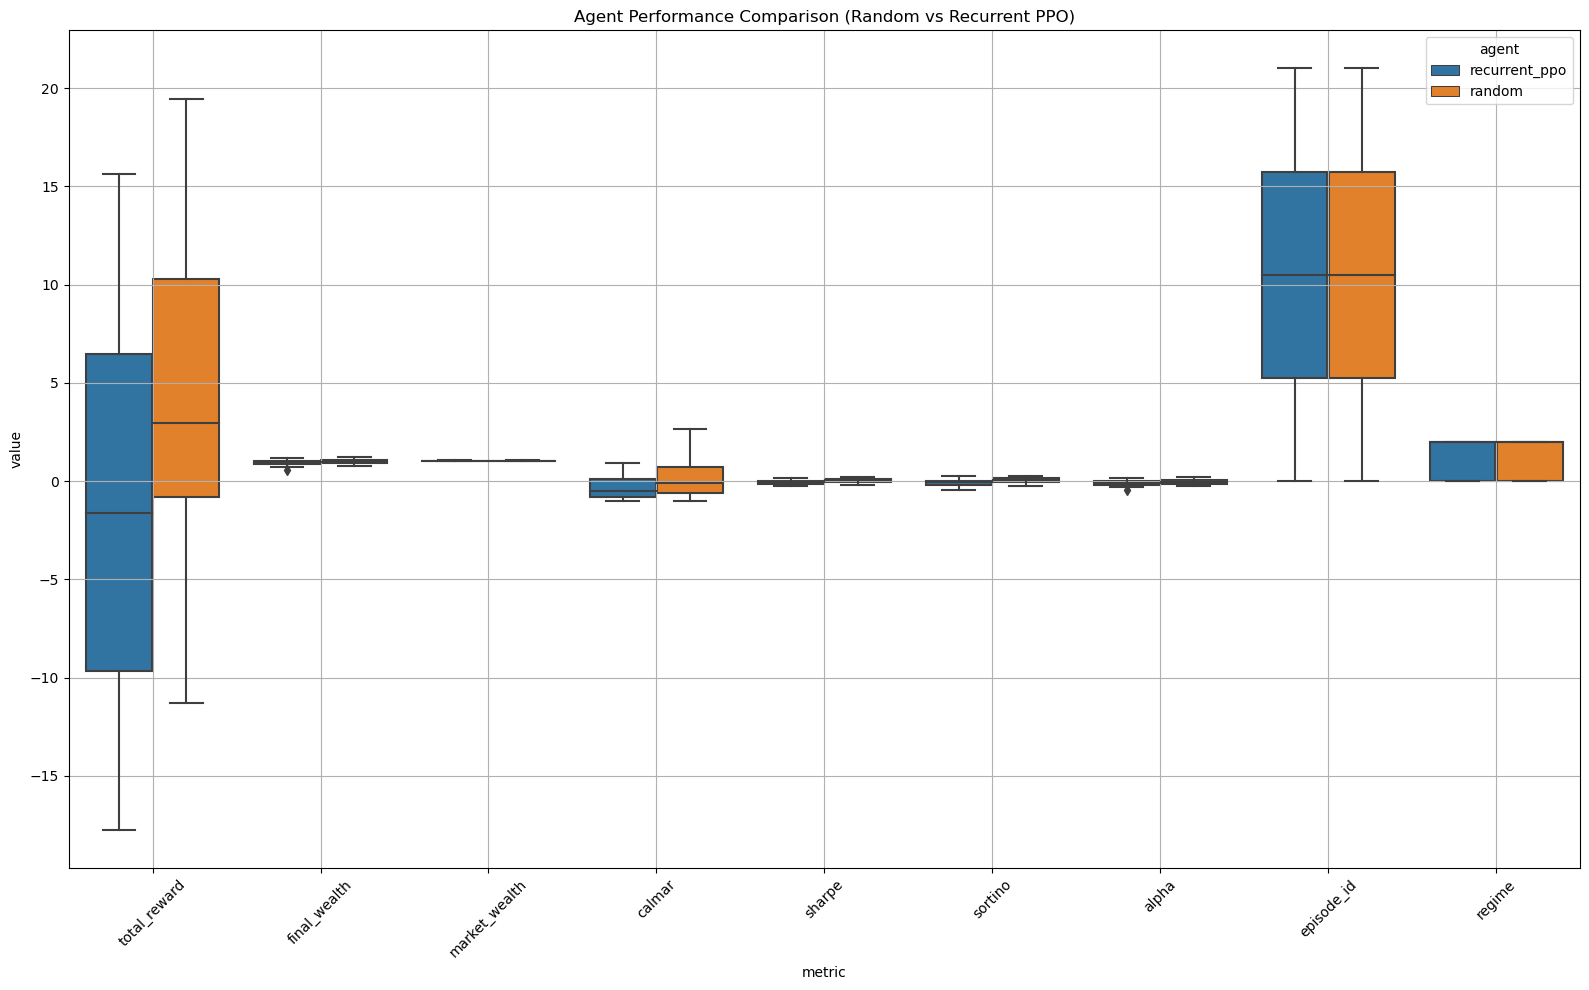

,metric,t-test p-value,mann-whitney p-value
0,total_reward,0.058903,0.084485
1,final_wealth,0.083271,0.093290
2,market_wealth,1.000000,1.000000
3,calmar,0.024981,0.076364
4,sharpe,0.012514,0.014171
5,sortino,0.007956,0.014171
6,alpha,0.083209,0.113102
7,episode_id,1.000000,1.000000
8,regime,1.000000,1.000000


In [8]:
# === Imports ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_ind, mannwhitneyu

from sb3_contrib import RecurrentPPO
#from src.env.base_timeseries_trading_env import SequenceAwareCumulativeTradingEnv
from src.defaults import TOP2_STOCK_BY_SECTOR, EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
#from src.env.base_timeseries_trading_env import RegimeAugmentingWrapper

ENV_CLASS=SequenceAwareCumulativeTradingEnv
# === Config ===
N_EVAL_EPISODES = 5
MODEL_PATH = save_path

# === Load Data ===
ohlcv_df = load_base_dataframe()
test_df = ohlcv_df[(ohlcv_df['date'] >= "2023-07-01") & (ohlcv_df['date'] < "2024-01-01")]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]


# === Evaluation Logic ===
def evaluate_agent(agent, env, n_episodes=22):
    episode_metrics = []
    episode_infos = []

    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        done = False
        state = None
        rewards = []
        infos = []

        # === Tracker setup ===
        tracker = MarketVersusWalletHistoryTracker()
        initial_price = env.env.env.episode_df.iloc[0]['close']
        tracker.reset(initial_price)

        while not done:
            action, state = agent.predict(obs, state=state, deterministic=True)
            action = int(action)
            current_price = env.env.env.episode_df.iloc[env.env.env.current_step]['close']

            # Step the wallet tracker
            tracker.step(action, current_price)

            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        # === Episode summary ===
        _env = env.env.env
        agent_wealth = infos[-1].get("final_wealth", np.nan)
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)
        alpha = agent_wealth - market_wealth

        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": agent_wealth,
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha": alpha,
            "episode_id": _env.episode_counter,
            "regime": infos[-1].get("regime", np.nan)
        }

        tracker_data = tracker.export()
        info["ticker"] = _env.episode_df.iloc[0]['symbol']
        info["wallet_history"] = tracker_data["wallet_history"]
        info["market_history"] = tracker_data["market_history"]
        info["market_price_history"] = tracker_data["market_price_history"]
        info["performed_action_history"] = tracker_data["performed_action_history"]
        episode_infos.append(info)
        episode_metrics.append(metrics)

    return pd.DataFrame(episode_metrics), episode_infos

def evaluate_random_agent( env, n_episodes=22):
    episode_metrics = []
    episode_infos = []

    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        done = False
        state = None
        rewards = []
        infos = []

        # === Tracker setup ===
        tracker = MarketVersusWalletHistoryTracker()
        initial_price = env.env.env.episode_df.iloc[0]['close']
        tracker.reset(initial_price)
        initial_symbol =env.env.env.episode_df.iloc[0]['symbol']
        #print(initial_symbol,env.env.env.episode_df.iloc[0]['date'],len(env.env.env.episode_df),env.env.env.episode_counter,env.env.env.episode_sequence)
        while not done:
            action=  env.action_space.sample()
            action = int(action)
            current_price = env.env.env.episode_df.iloc[env.env.env.current_step]['close']
            current_symbol = env.env.env.episode_df.iloc[env.env.env.current_step]['symbol']
            if(current_symbol != initial_symbol):
                print('EPISODE SWITCHED', initial_symbol,current_symbol)
                initial_symbol = current_symbol
            # Step the wallet tracker
            tracker.step(action, current_price)

            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)
        #print(current_symbol)
        # === Episode summary ===
        _env = env.env.env
        agent_wealth = infos[-1].get("final_wealth", np.nan)
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)
        alpha = agent_wealth - market_wealth

        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": agent_wealth,
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha": alpha,
            "episode_id": _env.episode_counter,
            "regime": infos[-1].get("regime", np.nan)
        }

        tracker_data = tracker.export()
        info["ticker"] = _env.episode_df.iloc[0]['symbol']
        info["wallet_history"] = tracker_data["wallet_history"]
        info["market_history"] = tracker_data["market_history"]
        info["market_price_history"] = tracker_data["market_price_history"]
        info["performed_action_history"] = tracker_data["performed_action_history"]
        episode_infos.append(info)
        episode_metrics.append(metrics)

    return pd.DataFrame(episode_metrics), episode_infos


# === Run Evaluation ===

model = RecurrentPPO.load(MODEL_PATH)

def make_test_env():
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env.set_episode_sequence(test_seq)
    return PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env)) #RegimeAugmentingWrapper(ENV_CLASS(test_df, episode_length=EPISODE_LENGTH,feature_cols=FEATURE_COLS))


ppo_agent_df, ppo_agent_infos = evaluate_agent(model, make_test_env(), n_episodes=22)
random_agent_df, random_agent_infos = evaluate_random_agent(make_test_env(), n_episodes=22)

ppo_agent_df["agent"] = "recurrent_ppo"
random_agent_df["agent"] = "random"
results_df = pd.concat([ppo_agent_df, random_agent_df])


# === Plotting ===
melted = results_df.melt(id_vars="agent", var_name="metric", value_name="value")
plt.figure(figsize=(16, 10))
sns.boxplot(data=melted, x="metric", y="value", hue="agent")
plt.title("Agent Performance Comparison (Random vs Recurrent PPO)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# === Statistical Tests ===
comparison_results = []

for metric in ppo_agent_df.columns[:-1]:  # exclude 'agent'
    a = ppo_agent_df[metric].dropna()
    b = random_agent_df[metric].dropna()

    # Skip if either is empty
    if len(a) == 0 or len(b) == 0:
        print(f"Skipping metric {metric}: empty values")
        continue

    t_stat, p_val_t = ttest_ind(a, b)
    u_stat, p_val_u = mannwhitneyu(a, b, alternative='two-sided')
    comparison_results.append({
        "metric": metric,
        "t-test p-value": p_val_t,
        "mann-whitney p-value": p_val_u
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df



In [9]:
make_test_env().env.env.episode_sequence

[('PLD', 8),
 ('JPM', 17),
 ('CVX', 18),
 ('AMZN', 4),
 ('GOOGL', 13),
 ('AAPL', 6),
 ('XOM', 14),
 ('TSLA', 3),
 ('LIN', 15),
 ('COST', 14),
 ('MSFT', 0),
 ('NEE', 3),
 ('LLY', 4),
 ('GE', 2),
 ('WMT', 9),
 ('META', 16),
 ('AMT', 4),
 ('UBER', 2),
 ('V', 5),
 ('UNH', 3),
 ('SO', 1),
 ('SHW', 13)]

<Axes: xlabel='market_wealth', ylabel='alpha'>

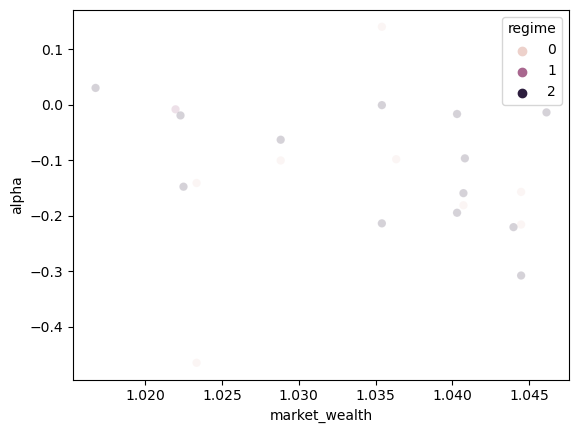

In [10]:
sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='regime', alpha=0.2)

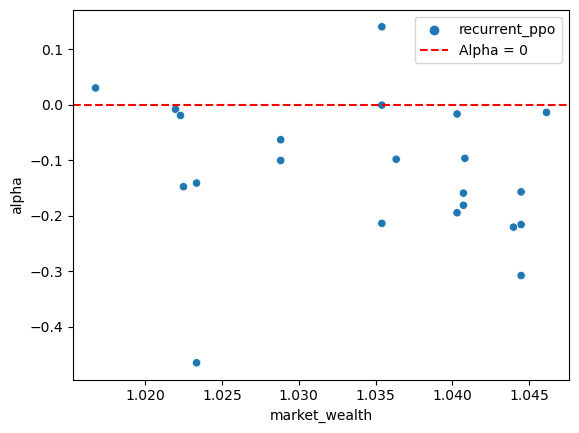

In [11]:

sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='agent')
plt.axhline(0, linestyle='--', color='red', label='Alpha = 0')
plt.legend()
plt.show()

<Axes: xlabel='agent', ylabel='alpha_ratio'>

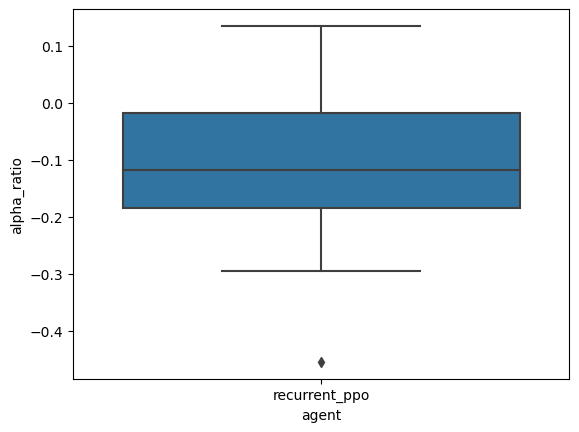

In [12]:
ppo_agent_df['alpha_ratio'] = ppo_agent_df['alpha'] / np.abs(ppo_agent_df['market_wealth'] + 1e-8)
sns.boxplot(data=ppo_agent_df, x='agent', y='alpha_ratio')

In [13]:
episode_complete_results = []
for i in range(len(ppo_agent_infos)):# or select based on alpha, reward, etc.
#for i in range(5):# or select based on alpha, reward, etc.
    info = ppo_agent_infos[i]
    info_ = random_agent_infos[i]
    """
    plt.figure(figsize=(8, 4))
    plt.plot(info['market_history'], label='Market')
    plt.plot(info['wallet_history'], label='Wallet (Agent)')
    plt.plot(info_['wallet_history'], label='Wallet (Random)')
    plt.title(f"Episode {info.get('episode_id')} - {info.get('ticker')}")
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    episode_complete_results.append({
        "agent_wallet":info['wallet_history'][-1],
        "random_wallet":info_['wallet_history'][-1],
        "market_wallet":info_['market_history'][-1],
                                   })
episode_complete_results_df = pd.DataFrame(episode_complete_results)
episode_complete_results_df['agent>random']=episode_complete_results_df['agent_wallet']>episode_complete_results_df['random_wallet']
episode_complete_results_df['agent>market']=episode_complete_results_df['agent_wallet']>episode_complete_results_df['market_wallet']
print("AGENT > RANDOM value counts",episode_complete_results_df['agent>random'].value_counts())
print("AGENT > MARKET value counts",episode_complete_results_df['agent>market'].value_counts())
episode_complete_results_df

AGENT > RANDOM value counts agent>random
False    13
True      9
Name: count, dtype: int64
AGENT > MARKET value counts agent>market
False    14
True      8
Name: count, dtype: int64


,agent_wallet,random_wallet,market_wallet,agent>random,agent>market
0,1.000000,0.978691,0.931898,True,True
1,1.000000,1.087946,1.079669,False,False
2,1.000000,0.922024,0.945742,True,True
3,1.000000,1.198967,1.149139,False,False
4,1.000000,1.007574,1.104566,False,False
5,1.000000,0.959951,0.998208,True,True
6,1.000000,0.918041,0.962661,True,True
7,1.000000,0.844326,0.889626,True,True
8,1.000000,0.998535,1.041786,True,False
9,1.000000,1.068784,1.118543,False,False


In [14]:
from scipy.stats import binom_test

n_wins = episode_complete_results_df['agent>random'].sum()
n_trials = len(episode_complete_results_df)

p_val = binom_test(n_wins, n_trials, p=0.5, alternative='greater')
print(f"PPO wins over Random: {n_wins}/{n_trials}, binomial p-value = {p_val:.4f}")

PPO wins over Random: 9/22, binomial p-value = 0.8569


In [15]:
w_p_df = pd.DataFrame({"wallet":ppo_agent_infos[0]["wallet_history"],"price":ppo_agent_infos[0]["market_price_history"],"performed_action":ppo_agent_infos[0]["performed_action_history"]})
for i in range(len(w_p_df)):
    print({"i":i,"wallet":w_p_df.iloc[i]["wallet"], "price":w_p_df.iloc[i]["price"], "performed_action":w_p_df.iloc[i]["performed_action"]})

{'i': 0, 'wallet': 1.0, 'price': 127.75, 'performed_action': 0.0}
{'i': 1, 'wallet': 1.0, 'price': 127.75, 'performed_action': 0.0}
{'i': 2, 'wallet': 1.0, 'price': 127.98, 'performed_action': 0.0}
{'i': 3, 'wallet': 1.0, 'price': 124.0, 'performed_action': 0.0}
{'i': 4, 'wallet': 1.0, 'price': 122.78, 'performed_action': 0.0}
{'i': 5, 'wallet': 1.0, 'price': 123.76, 'performed_action': 0.0}
{'i': 6, 'wallet': 1.0, 'price': 125.44, 'performed_action': 0.0}
{'i': 7, 'wallet': 1.0, 'price': 127.01, 'performed_action': 0.0}
{'i': 8, 'wallet': 1.0, 'price': 127.1, 'performed_action': 0.0}
{'i': 9, 'wallet': 1.0, 'price': 129.28, 'performed_action': 0.0}
{'i': 10, 'wallet': 1.0, 'price': 124.94, 'performed_action': 0.0}
{'i': 11, 'wallet': 1.0, 'price': 123.65, 'performed_action': 0.0}
{'i': 12, 'wallet': 1.0, 'price': 124.75, 'performed_action': 0.0}
{'i': 13, 'wallet': 1.0, 'price': 124.18, 'performed_action': 0.0}
{'i': 14, 'wallet': 1.0, 'price': 123.68, 'performed_action': 0.0}
{'i': 1

In [16]:
len(ppo_agent_infos[0]["performed_action_history"]),len(ppo_agent_infos[0]["market_price_history"]),len(info["returns"])

(103, 103, 102)

In [17]:
info

{'regime': 0,
 'episode_sharpe': -0.08610010364542489,
 'episode_sortino': -0.12507796629110876,
 'episode_total_reward': -0.141928057463937,
 'cumulative_return': -0.14063102772652603,
 'calmar': -0.5865050020680675,
 'max_drawdown': 0.2397780534362858,
 'win_rate': 0.0,
 'alpha': -0.17827150441037232,
 'returns': array([ 0.00264206, -0.02962465, -0.01790115,  0.01367035, -0.01104454,
         0.01292303, -0.01338156,  0.00899358,  0.01602564, -0.00120777,
        -0.00277818,  0.00550452,  0.00476522, -0.00497219, -0.0031518 ,
        -0.0106313 ,  0.00495246,  0.00795611,  0.01845681, -0.00790956,
        -0.00085138, -0.00011095, -0.00606486,  0.01036574,  0.01708576,
        -0.00653743, -0.0153927 ,  0.00125712, -0.00592329, -0.0114088 ,
         0.01903064,  0.00192885, -0.0077675 , -0.00106948, -0.00810462,
         0.01797917,  0.00100473,  0.00145273,  0.02402358,  0.00642128,
        -0.00565493,  0.00615867,  0.02089989, -0.00114003, -0.00604704,
         0.00913313,  0.012

KeyError: 'reward_history'

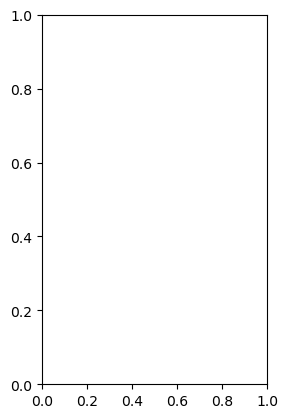

In [18]:
# REWARD ANALYSIS

import matplotlib.pyplot as plt

# Pick one episode
info = ppo_agent_infos[0]  # or any i
rewards = info["episode_total_reward"]
returns = np.array([1]+info["returns"].tolist())
cum_rewards = np.cumsum(returns* info["performed_action_history"])  # or info['reward_history'] if saved
cum_returns = np.cumprod(1 + np.array(returns)) - 1

#plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 1)
#plt.plot(cum_returns, label="Cumulative Return")
#plt.plot(np.cumsum(info["reward_history"]), label="Cumulative Reward")
#plt.title("Cumulative Return vs Reward")
#plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(np.cumsum(info["reward_history"]), cum_returns)
plt.xlabel("Cumulative Reward")
plt.ylabel("Cumulative Return")
plt.title("Reward vs Return Correlation")
plt.grid(True)
plt.show()

In [ ]:
"""
corr(reward, return) ≥ 0.7 ⇒ strong alignment

corr(reward, alpha) ≥ 0.6 ⇒ good relative performance

If < 0.3 → your agent may be overfitting to reward noise or not capturing actual alpha
"""
reward_list = []
return_list = []
alpha_list = []

for info in ppo_agent_infos:
    reward_list.append(np.sum(info["reward_history"]))
    return_list.append(info["final_wealth"] - 1)
    alpha_list.append(info["alpha"])

import pandas as pd
df = pd.DataFrame({
    "reward": reward_list,
    "return": return_list,
    "alpha": alpha_list
})

print(df.corr())
sns.pairplot(df)

In [19]:
save_path #'data/checkpoint/-8377624099423380081--final'

'data/checkpoint/-8377624099423380081--final'